* The code in this file implements the randomized svd based on pseudocodes of the rsvd library.
* The rsvd library and its write up can be found at: https://github.com/erichson/rSVD and https://arxiv.org/pdf/1608.02148.pdf

In [2]:
import pandas as pandas
import random as rd
import numpy as np

* Generate A for use

In [94]:
# A is mxn and rank k.
m = 2000
n = 2000
k = 20
randomRange = 100
randU = np.zeros((m,m))
for i in list(range(0,m)):
    randU[i] = np.random.choice(randomRange,m)/100 #m*m by random range 1~100
randV = np.zeros((n,n))
for i in list(range(0,n)):
    randV[i] = np.random.choice(randomRange,n)/100 #n*n by random range 1~100
P = np.diag([1]*k + [0]*(m-k))

#matmul is quite slow...
A = np.matmul(randU,P) #You can't just use *!!! You have to use matmul function.
A = np.matmul(A,randV)
print(A)

[[5.7476 4.4558 4.8515 ... 4.7822 4.67   5.1844]
 [5.1656 5.3062 5.7215 ... 5.4564 4.7711 5.6947]
 [4.9487 4.2724 4.8434 ... 4.1129 3.8378 4.9958]
 ...
 [5.5343 4.9341 5.1085 ... 5.2254 5.0698 5.8547]
 [4.7141 3.7066 4.1004 ... 4.7053 4.4773 5.0054]
 [5.8679 4.5298 5.4019 ... 5.0081 4.9513 6.0648]]


# rsvd implementation in python

* Step1: compute $Q$  used in $A\approx Q Q^T A = QB$
    0. Preprocess $A$ to $A^{(q)} := (AA^T)^{(q)}A$
    1. Generate Random Matrix $\Omega$
    2. Apply QR-decomp to $Y:=A\Omega = QR$

In [38]:
# Generate Random Matrix Omega(nxk)
q = 2 # Preprocessing (page 9 of the write up of rsvd) for better computation, applied later with Y
k = 30 # How many random vectors you want to use -> changes the size of Omega.
p = 10 # OverSampling
l = k+p # l is lowercase L
Omega = []
for i in list(range(0,l)):
    w = (np.random.choice(int(n/10),n))/100 # n is the column number of A
    Omega.append(w)
print(Omega) # Omega is a collection of k+p random vectors
Omega = np.column_stack(Omega) # Merge all k+p vectors into a matrix Omega.
print(Omega)

[array([1.61, 1.33, 1.34, ..., 1.72, 1.69, 0.42]), array([0.09, 1.96, 1.38, ..., 0.62, 0.49, 1.97]), array([0.86, 0.12, 1.49, ..., 1.73, 1.5 , 0.83]), array([1.67, 1.14, 1.26, ..., 0.29, 0.18, 0.44]), array([1.77, 0.57, 0.58, ..., 1.09, 1.28, 0.57]), array([1.1 , 1.12, 0.97, ..., 1.08, 0.53, 0.82]), array([0.52, 1.58, 0.4 , ..., 1.62, 1.52, 1.87]), array([1.48, 0.45, 0.21, ..., 0.17, 1.01, 1.37]), array([0.13, 0.63, 0.04, ..., 0.94, 0.89, 1.01]), array([1.05, 1.11, 1.61, ..., 1.12, 0.29, 0.5 ]), array([0.69, 0.09, 0.11, ..., 1.12, 0.91, 0.22]), array([0.07, 1.18, 0.36, ..., 0.28, 0.81, 0.35]), array([1.5 , 0.76, 1.83, ..., 1.15, 1.52, 0.82]), array([0.94, 1.59, 1.77, ..., 0.63, 0.29, 1.23]), array([1.29, 0.21, 0.19, ..., 1.21, 0.12, 0.34]), array([1.78, 1.18, 0.01, ..., 1.22, 0.4 , 1.87]), array([1.05, 1.25, 1.98, ..., 0.4 , 1.1 , 0.51]), array([1.64, 1.72, 0.19, ..., 1.96, 0.97, 1.77]), array([1.  , 1.67, 1.23, ..., 1.35, 0.68, 1.81]), array([0.46, 1.98, 0.21, ..., 1.26, 1.47, 1.3 ]),

In [42]:
# Apply QR-decomp to A*Omega with preprocess amount q (refer to page 9 in the write up by Erichson)
Y = np.matmul(A,Omega)
for i in list(range(0,q)):
    Q, R = np.linalg.qr(Y)
    Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
    Y = np.matmul(A,Q)
Q, R = np.linalg.qr(Y)

* Step2: $A \approx QQ^{T}A = QB = Q\hat{U}\Sigma V^{T} = U\Sigma V^{T}$

In [44]:
# Apply traditional svd on B and gain approx svd for A
B = np.matmul(np.transpose(Q),A)
U_hat, S, V_t = np.linalg.svd(B)
U = np.matmul(Q,U_hat)
# Now svd for A is approx U, S, V_t

In [50]:
# True SVD of A
U2,S2,V2 = np.linalg.svd(A)

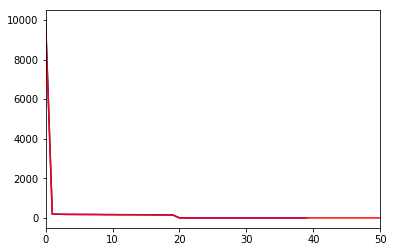

In [80]:
import matplotlib.pyplot as plt
plt.plot(S,color = "blue")
plt.plot(S2,color="red")
plt.xlim(0,50)
#plt.ylim(0,100)
plt.show()
########### LOOK CLOSELY ON THE 39 MARK. YOU CAN SEE WHERE SVD OF B ENDS. THIS PROVES HOW ACCURATE IT IS

In [76]:
# Difference in size of the approximated spectrum and the true spectrum. It is very small.
concS2 = S2[:40]
diff = np.linalg.norm(concS2-S)
print(diff)

5.977053044981967e-12


# Diverse Insights

* Decay in spectrum for preprocessed and non-preprocessed matrices (page 8 of rsvd write up by Erichson)

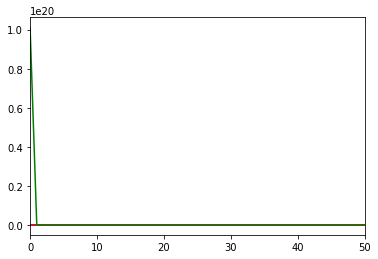

In [95]:
# True Spectrum vs Preprocessed Spectrum
U2,S2,V2 = np.linalg.svd(A)
AAT = np.matmul(A,np.transpose(A))
A_1 = np.matmul(AAT,A)
U3,S3,V3 = np.linalg.svd(A_1)
A_2 = np.matmul(AAT,A_1)
U4,S4,V4 = np.linalg.svd(A_2)

import matplotlib.pyplot as plt
plt.plot(S2,color = "blue")
plt.plot(S3,color="red")
plt.plot(S4,color="green")
plt.xlim(0,50)
plt.show()

# Time Comparison

In [82]:
import time

In [85]:
#### normal svd

start = time.time()
U2,S2,V2 = np.linalg.svd(A)
end = time.time()

print(end-start)

5.034790754318237


In [86]:
#### rsvd with q=2 k=30 => 10 times faster than normal svd

start = time.time()
# Generate Random Matrix Omega(nxk)
q = 2 # Preprocessing (page 9 of the write up of rsvd) for better computation, applied later with Y
k = 30 # How many random vectors you want to use -> changes the size of Omega.
p = 10 # OverSampling
l = k+p # l is lowercase L
Omega = []
for i in list(range(0,l)):
    w = (np.random.choice(int(n/10),n))/100 # n is the column number of A
    Omega.append(w)
Omega = np.column_stack(Omega) # Merge all k+p vectors into a matrix Omega.
# Apply QR-decomp to A*Omega with preprocess amount q (refer to page 9 in the write up by Erichson)
Y = np.matmul(A,Omega)
for i in list(range(0,q)):
    Q, R = np.linalg.qr(Y)
    Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
    Y = np.matmul(A,Q)
Q, R = np.linalg.qr(Y)
# Apply traditional svd on B and gain approx svd for A
B = np.matmul(np.transpose(Q),A)
U_hat, S, V_t = np.linalg.svd(B)
U = np.matmul(Q,U_hat)
# Now svd for A is approx U, S, V_t
end = time.time()

print(end-start)

0.5161824226379395


In [91]:
#### rsvd with q=0 k=2

start = time.time()
# Generate Random Matrix Omega(nxk)
q = 0 # Preprocessing (page 9 of the write up of rsvd) for better computation, applied later with Y
k = 2 # How many random vectors you want to use -> changes the size of Omega.
p = 0 # OverSampling
l = k+p # l is lowercase L
Omega = []
for i in list(range(0,l)):
    w = (np.random.choice(int(n/10),n))/100 # n is the column number of A
    Omega.append(w)
Omega = np.column_stack(Omega) # Merge all k+p vectors into a matrix Omega.
# Apply QR-decomp to A*Omega with preprocess amount q (refer to page 9 in the write up by Erichson)
Y = np.matmul(A,Omega)
for i in list(range(0,q)):
    Q, R = np.linalg.qr(Y)
    Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
    Y = np.matmul(A,Q)
Q, R = np.linalg.qr(Y)
# Apply traditional svd on B and gain approx svd for A
B = np.matmul(np.transpose(Q),A)
U_hat, S, V_t = np.linalg.svd(B)
U = np.matmul(Q,U_hat)
# Now svd for A is approx U, S, V_t
end = time.time()

print(end-start)

0.15802979469299316


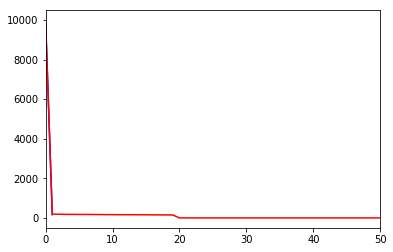

In [92]:
#### how about how accurate q=0 and k=2 is?
import matplotlib.pyplot as plt
plt.plot(S,color = "blue")
plt.plot(S2,color="red")
plt.xlim(0,50)
#plt.ylim(0,100)
plt.show()

In [ ]:
#### super exact... WHY?

# Consideration & Discussion

* No matter how many times $A$ is generated, it always has rapid decay of spectrum.
* We want random matrix that has gradual decay of spectrum for better experimentations of rsvd.
* It seems like very low amount of random vectors (Omega) still capture the spectrum very well. Is there flaw in the codes?
* Might be that since our matrix $A$ seems like to have very quick decay in spectrum, so it made B to be calculated with high accuracy??
